In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset


In [14]:
def split_matrix(X, block_size):
    I, J = X.shape
    blocks = []

    for i in range(0, I, block_size):
        for j in range(0, J, block_size):
            sub_matrix = X[i:i+block_size, j:j+block_size]
            blocks.append((i, j, sub_matrix))

    return blocks


In [15]:
class OpenTensorNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(OpenTensorNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [16]:
def sparse_matrix_multiplication(A, B):
    A_sparse = A.to_sparse()
    B_sparse = B.to_sparse()
    return torch.sparse.mm(A_sparse, B_sparse)


In [17]:
def compress_matrix(X, rank=50):

    U, S, Vt = torch.svd(X)
    U_r = U[:, :rank]
    S_r = torch.diag(S[:rank])
    Vt_r = Vt[:rank, :]

    return U_r @ S_r @ Vt_r


In [22]:
import matplotlib.pyplot as plt

def train_model(model, dataloader, epochs=10, lr=0.001):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0

        for inputs, targets in dataloader:
            inputs = inputs.view(inputs.shape[0], -1)
            targets = targets.view(targets.shape[0], -1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), loss_history, label="Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Évolution de la Perte du Modèle")
    plt.legend()
    plt.grid()
    plt.show()


In [23]:
def visualize_results(model, dataloader):
    model.eval()

    inputs, targets = next(iter(dataloader))
    inputs = inputs.view(inputs.shape[0], -1)
    targets = targets.view(targets.shape[0], -1)

    outputs = model(inputs).detach()


    idx = 0
    original = targets[idx].view(500, 500).cpu().numpy()
    reconstructed = outputs[idx].view(500, 500).cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(original, cmap="viridis")
    ax[0].set_title("Matrice Originale")

    ax[1].imshow(reconstructed, cmap="viridis")
    ax[1].set_title("Matrice Reconstituée")

    plt.show()


Epoch [1/10], Loss: 25.3092
Epoch [2/10], Loss: 22.2285
Epoch [3/10], Loss: 12.1921
Epoch [4/10], Loss: 7.2369
Epoch [5/10], Loss: 4.2454
Epoch [6/10], Loss: 1.8489
Epoch [7/10], Loss: 0.7694
Epoch [8/10], Loss: 0.4371
Epoch [9/10], Loss: 0.3212
Epoch [10/10], Loss: 0.2971


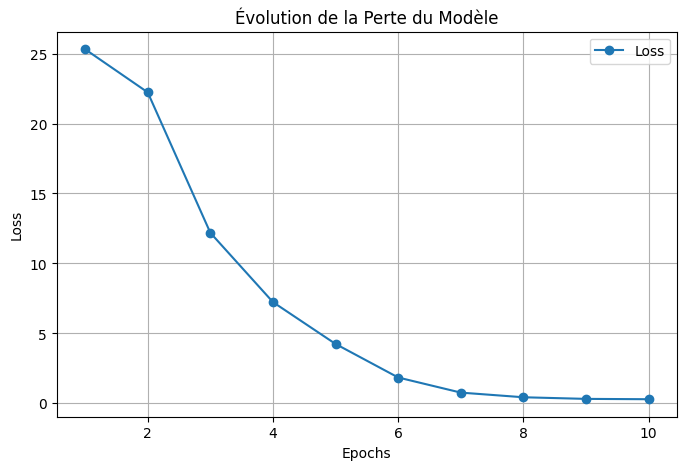

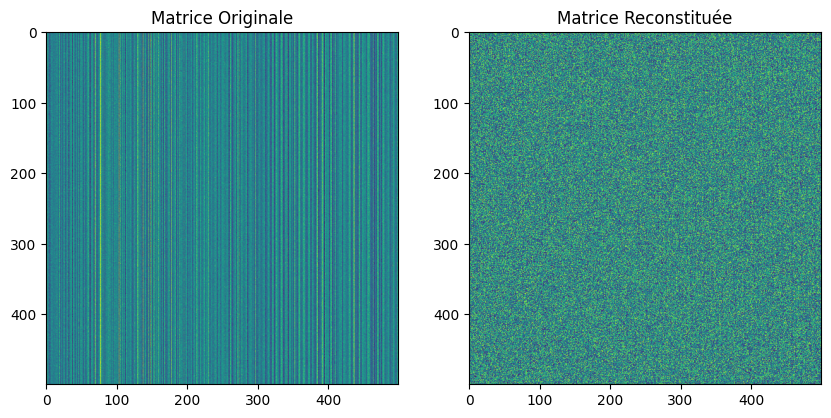

In [24]:
X_large = torch.rand(5000, 5000)

block_size = 500
blocks = split_matrix(X_large, block_size)


compressed_blocks = [(i, j, compress_matrix(block)) for i, j, block in blocks]


input_dim = block_size ** 2
hidden_dim, output_dim = 256, input_dim


model = OpenTensorNN(input_dim, hidden_dim, output_dim)

dataset = [(block.flatten(), block.flatten()) for _, _, block in compressed_blocks]
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


train_model(model, dataloader)
visualize_results(model, dataloader)